# Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## PCA with undercomplete linear autoencoder

In [2]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
# build dataset
np.random.seed(42)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
    
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 1.0670
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.6809
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.5032
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4004
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3329
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2859
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2503
Epoch 8/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2239
Epoch 9/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2032
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1859
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1718
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1598
Epoch 13/20
2/2 [==============================] - 0s 1ms/step - loss: 0.

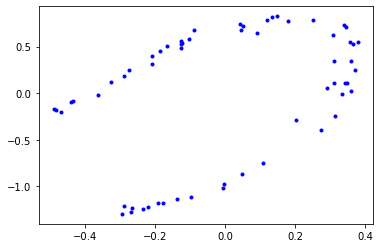

In [6]:
codings = encoder.predict(X_train)

plt.plot(codings[:, 0], codings[:, 1], 'b.')

## Stacked autoencoder for MNIST

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32)/255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()


stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=1, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006


In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

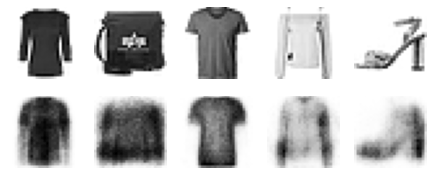

In [11]:
show_reconstructions(stacked_ae)

# Lower dims for fashion mnist

In [12]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

(0.016916798800230025,
 1.0468134857714175,
 -0.04743062257766724,
 0.996043074131012)

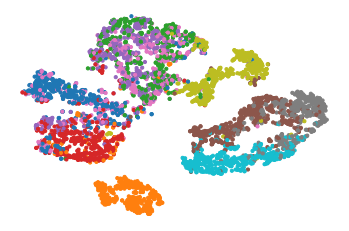

In [13]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')

# Convolutional Autoencoders

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
               metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=1, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 71s 41ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2849 - val_rounded_accuracy: 0.9288


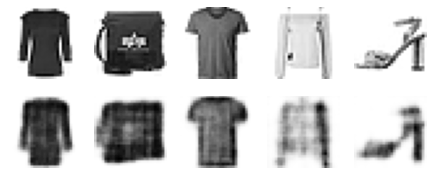

In [19]:
show_reconstructions(conv_ae)

# Denoising Autoencoders

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense()
])